In [1]:
import numpy as np
import pandas as pd
import six
import tensorflow as tf
import time
import os
from tqdm import tqdm

import random
import string

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

%matplotlib inline

SCRAPED_WINES_INPUT_PATH = 'data/scraped/names_prices_descriptions.pickle'
MODEL_WEIGHTS_PATH = 'data/models_weights/model_weights_name.h5'

Using TensorFlow backend.


In [2]:
tf.logging.set_verbosity(tf.logging.INFO)

def transform(txt, pad_to=None):
    # drop any non-ascii characters
    output = np.asarray([ord(c) for c in txt if ord(c) < 255], dtype=np.int32)
    if pad_to is not None:
        output = output[:pad_to]
        output = np.concatenate([
            np.zeros([pad_to - len(txt)], dtype=np.int32),
            output
        ])
    return output

def training_generator(seq_len=100, batch_size=1024):
    """A generator yields (source, target) arrays for training."""
    wine_data = pd.read_pickle(SCRAPED_WINES_INPUT_PATH)
    wine_data = wine_data['name'] # Take just the names for modeling
    txt = '\n'.join(wine_data)

    tf.logging.info('Input text [%d] %s', len(txt), txt[:50])
    source = transform(txt)
    while True:
        offsets = np.random.randint(0, len(source) - seq_len, batch_size)

        # Our model uses sparse crossentropy loss, but Keras requires labels
        # to have the same rank as the input logits.  We add an empty final
        # dimension to account for this.
        yield (
            np.stack([source[idx:idx + seq_len] for idx in offsets]),
            np.expand_dims(
                np.stack([source[idx + 1:idx + seq_len + 1] for idx in offsets]), 
                -1),
        )

#six.next(training_generator(seq_len=10, batch_size=1))

# Define model and train it on dataset

In [4]:
EMBEDDING_DIM = 512

def lstm_model(seq_len=100, batch_size=None, stateful=True):
    """Language model: predict the next word given the current word."""
    source = tf.keras.Input(
        name='seed', shape=(seq_len,), batch_size=batch_size, dtype=tf.int32)

    embedding = tf.keras.layers.Embedding(input_dim=256, output_dim=EMBEDDING_DIM)(source)
    lstm_1 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(embedding)
    lstm_2 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(lstm_1)
    #drop_1 = tf.keras.layers.Dropout(0.2)
    predicted_char = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='softmax'))(lstm_2)
    model = tf.keras.Model(inputs=[source], outputs=[predicted_char])
    model.compile(
        optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01),
        #optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
    
    return model

tf.keras.backend.clear_session()

training_model = lstm_model(seq_len=100, batch_size=1024, stateful=False)
#training_model.load_weights('model_small_chkpt.h5', by_name=True)

checkpoint = ModelCheckpoint('model_names_chkpt.h5', 
                             monitor='sparse_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
early_stopping = EarlyStopping(monitor='sparse_categorical_accuracy',
                               patience=3,
                               mode='max')
callbacks_list = [checkpoint,early_stopping]

print(training_model.summary())

training_model.fit_generator(
    training_generator(seq_len=100, batch_size=1024),
    steps_per_epoch=100,
    epochs=2,
    callbacks = callbacks_list
    )

training_model.save_weights(MODEL_WEIGHTS_PATH, overwrite=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seed (InputLayer)            (1024, 100)               0         
_________________________________________________________________
embedding (Embedding)        (1024, 100, 512)          131072    
_________________________________________________________________
lstm (LSTM)                  (1024, 100, 512)          2099200   
_________________________________________________________________
lstm_1 (LSTM)                (1024, 100, 512)          2099200   
_________________________________________________________________
time_distributed (TimeDistri (1024, 100, 256)          131328    
Total params: 4,460,800
Trainable params: 4,460,800
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
INFO:tensorflow:Input text [614792] Hall Napa Valley Cabernet Sauvignon 2013
Rombauer 
  3/100 [.....................

KeyboardInterrupt: 

# Show sample of created wine names

In [6]:
BATCH_SIZE = 5
PREDICT_LEN = 250

# Keras requires the batch size be specified ahead of time for stateful models.
# We use a sequence length of 1, as we will be feeding in one character at a 
# time and predicting the next character.
prediction_model = lstm_model(seq_len=1, batch_size=BATCH_SIZE, stateful=True)
prediction_model.load_weights('data/models_weights/model_weights_name.h5')

seed_txt = ''.join(random.choices(string.ascii_uppercase + string.digits, k=20))
seed = transform(seed_txt)
seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)

# First, run the seed forward to prime the state of the model.
prediction_model.reset_states()
for i in range(len(seed_txt) - 1):
    prediction_model.predict(seed[:, i:i + 1])

# Now we can accumulate predictions!
predictions = [seed[:, -1:]]
for i in range(PREDICT_LEN):
    last_word = predictions[-1]
    next_probits = prediction_model.predict(last_word)[:, 0, :]
  
  # sample from our output distribution
    next_idx = [
        np.random.choice(256, p=next_probits[i])
        for i in range(BATCH_SIZE)
    ]
    predictions.append(np.asarray(next_idx, dtype=np.int32))
    
for i in range(BATCH_SIZE):
    print('PREDICTION %d\n\n' % i)
    p = [predictions[j][i] for j in range(PREDICT_LEN)]
    generated = ''.join([chr(c) for c in p])
    print(generated)
    print()
    assert len(generated) == PREDICT_LEN, 'Generated text too short'

PREDICTION 0


ALS 2014 
Big Skymouse Cabernet Sauvignon (1.5L Magnum) 2012 
Giraffe Wine Blend Chardonnay 2016 
Peter Paul Mas Chardonnay 2015 
Bonterra Orgus Viognier 2017 
Cielo y Tard Nacion Diante 2015 
Peter Lehmann Clancanes Old Vine Zinfandel 2015 
Chateau 

PREDICTION 1


AnShar Lespennelly Shea Vineyard Pinot Noir 2012 
Miguel Torres Las Mulakondelle 2013 
Pepperwood Grove Pinot Noir 2014 
Bryant Family Claret 2016 
Santa Cristina by Antinori Chianti Classico Riserva 2013 
Stony Hill Chardonnay 2014 
Ca'Momi Reserve 

PREDICTION 2


A Cabernet Sauvignon 2015 
Patrick Piuze Chablis Blanchot Grand Cru 2016 
Angulo Innocenti Nonni Malbec 2014 
Graham's 20 Year Old Tawny Port 
Morgadio Nobile di Montepulciano Riserva 2012 
Torreselli Primitivo 2015 
Bodegas y Vinedos Ilurce Rio Menc

PREDICTION 3


Aked Eola-Amity Hills Pinot Noir 2017 
Pieropan Soave Classico 2015 
CaliPaso Chardonnay 2016 
Masia Puigmaltavican Arianne 2015 
Liquid Farm FOEA Canary Islands Estate Chardonnay 2014

# Create larger fake wine name list

In [7]:
BATCH_SIZE = 5
PREDICT_LEN = 150
TOTAL_BATCHES = 1000

# We use a sequence length of 1, as we will be feeding in one character at a 
# time and predicting the next character.
prediction_model = lstm_model(seq_len=1, batch_size=BATCH_SIZE, stateful=True)
prediction_model.load_weights(MODEL_WEIGHTS_PATH)

fake_names = []
for ii in tqdm(range(TOTAL_BATCHES)):
    seed_txt = ''.join(random.choices(string.ascii_uppercase + string.digits, k=20))
    seed = transform(seed_txt)
    seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)

    # First, run the seed forward to prime the state of the model.
    prediction_model.reset_states()
    for i in range(len(seed_txt) - 1):
        prediction_model.predict(seed[:, i:i + 1])

    # Now we can accumulate predictions!
    predictions = [seed[:, -1:]]
    for i in range(PREDICT_LEN):
        last_word = predictions[-1]
        next_probits = prediction_model.predict(last_word)[:, 0, :]

      # sample from our output distribution
        next_idx = [
            np.random.choice(256, p=next_probits[i])
            for i in range(BATCH_SIZE)
        ]
        predictions.append(np.asarray(next_idx, dtype=np.int32))

    for i in range(BATCH_SIZE):
        #print('PREDICTION %d\n\n' % i)
        p = [predictions[j][i] for j in range(PREDICT_LEN)]
        generated = ''.join([chr(c) for c in p])
        gen_list = generated.split('\n')[1:-1]
        for item in gen_list:
            fake_names.append(item)
        assert len(generated) == PREDICT_LEN, 'Generated text too short'

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:54<00:00,  1.73it/s]


In [13]:
pd.to_pickle(fake_names, 'data/fake/fake_names_{}.pickle'\
             .format(len(fake_names)))

In [11]:
fake_names[203]

'Hdoy Vineyards Chardonnay 2014 '

# Compute fake wine name similarity


In [3]:
test = pd.read_csv('data/fake/fakes.csv', low_memory=False, sep='|')

In [18]:
pd.to_pickle(list(real_names),'real_name_list.pickle')

In [25]:
len(fake_names)

12949

In [51]:
fake_names[range(0,10)]

TypeError: list indices must be integers or slices, not range

In [52]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append((int(last),int(last + avg)))
        last += avg

    return out

chunkIt(range(12949), 8)

[(0, 1618),
 (1618, 3237),
 (3237, 4855),
 (4855, 6474),
 (6474, 8093),
 (8093, 9711),
 (9711, 11330),
 (11330, 12949)]

In [50]:
pd.read_pickle('new_scores.pickle')

[{'Blackbird Vineyards Alpine Vineyard Chenin Blanc 2014 ': 0.7,
  "Ca' Rugate Recaro Pinot Noir 2016 ": 0.7246376811594203,
  'Prunotto Bussia 2009 ': 0.7916666666666666,
  "Col d'Orcia Spezial Reserve Cabernet Sauvignon 2016 ": 0.7865168539325843,
  'Vino Gran Bastello di Amita 2013 ': 0.6176470588235294,
  'Oakville Peaks Paso Robles Cabernet Sauvignon 2014 ': 0.86,
  "Chateau d'Yquem Sauternes (Futures Pre-Sale) 2016 ": 0.88,
  'Santa Julia Plus Malbec 2017 ': 0.9824561403508771,
  'Neely Spring Charms ': 0.7441860465116279,
  'J.J. Prum Decina Chardonnay ': 0.6296296296296297},
 {'Windy Oaks Santa Carbardes 2015 ': 0.6666666666666666,
  'Birichino Saint Georges Pinot Noir 2016 ': 0.9620253164556962,
  'Jeff Runquist R Petit Batard-Montrachet Les Vergers Premier Cru 2016 ': 0.7111111111111111,
  'Francis Ford Coppola Diamond Collection Chardonnay 2015 ': 0.972972972972973,
  "Cooper &amp; Thief Bourbon Barbera d'Alba 2016 ": 0.8085106382978723,
  'Chamonix Reserve Pinot Noir 2014 '

In [14]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

#fake_names = test['name']
real_names = pd.read_pickle(SCRAPED_WINES_INPUT_PATH)['name']

fake_scores = {}
for f_name in tqdm(fake_names):
    max_score = 0.0
    for r_name in real_names:
        score = similar(f_name, r_name)
        if score > max_score:
            max_score = score
    fake_scores[f_name] = max_score
        
    
fake_scores = pd.Series(fake_scores)

  0%|▎                                                                                                       | 39/12949 [01:36<8:45:11,  2.44s/it]

KeyboardInterrupt: 

In [ ]:
fake_scores = pd.Series(fake_scores).sort_values(ascending=False)
fake_scores.head()

In [4]:
2+2

4

In [ ]:
from multiprocessing import Pool

def square(x):  
    # calculate the square of the value of x
    return x*x


# Define the dataset
dataset = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Output the dataset
print ('Dataset: ' + str(dataset))

# Run this with a pool of 5 agents having a chunksize of 3 until finished
agents = 5
chunksize = 3
p = Pool(processes=agents)
print(p.map(square, [1, 2, 3]))

# Output the result
print ('Result:  ' + str(result))

Dataset: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


Total fake names:  1275
Total 90% or less match:  895


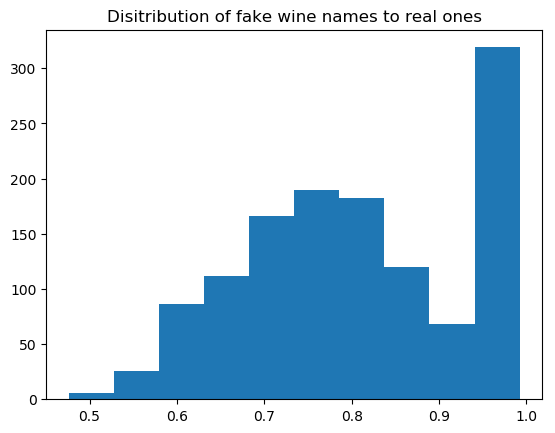

In [44]:
import matplotlib.pyplot as plt
plt.style.use('default')

print("Total fake names: ",len(fake_scores))
print("Total 90% or less match: ",len(fake_scores[fake_scores < 0.9]))

plt.figure(dpi=100)
plt.title('Disitribution of fake wine names to real ones')
plt.hist(fake_scores.values)
plt.show()